**Part 1 - Introduction to Bioinformatics**


In [1]:
## This code block imports python modules to work with during the lab, you need to run it first to get started.
# modules
import nglview
import os
import shutil
from Bio.PDB import PDBParser, PDBIO, Select,  PDBList, MMCIFParser, StructureAlignment
import Bio.Align
import os
from pathlib import Path
import rdkit

# local scripts
from scripts import viewer
from scripts import bio_align

/opt/conda/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


In [2]:
!pip install chembl_webresource_client
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [4]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [5]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In [6]:
uniprot_id = "Q16539"


In [7]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [8]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,MAP kinase p38 alpha,CHEMBL260,SINGLE PROTEIN
1,Homo sapiens,MAP kinase p38 alpha,CHEMBL260,SINGLE PROTEIN
2,Homo sapiens,MAP kinase p38,CHEMBL2094115,PROTEIN FAMILY
3,Homo sapiens,p38 MAP kinase alpha/beta,CHEMBL4106180,PROTEIN FAMILY


In [9]:
#CHEMBL260 ID

In [10]:
target = targets.iloc[0]
target

organism                    Homo sapiens
pref_name           MAP kinase p38 alpha
target_chembl_id               CHEMBL260
target_type               SINGLE PROTEIN
Name: 0, dtype: object

In [11]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL260


In [12]:
# Get the bioactivity data
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 4837, <class 'chembl_webresource_client.query_set.QuerySet'>


In [13]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 45892,
 'assay_chembl_id': 'CHEMBL732625',
 'assay_description': 'Inhibition of Mitogen-activated protein kinase p38 (P38 MAPK)',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL10',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '290.0',
 'target_chembl_id': 'CHEMBL260',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.29'}

In [14]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (4838, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,45892,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL10,=,nM,290.0,CHEMBL260,Homo sapiens,IC50,uM,0.29
1,45892,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL10,=,nM,290.0,CHEMBL260,Homo sapiens,IC50,uM,0.29
2,48475,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL143370,=,nM,2100.0,CHEMBL260,Homo sapiens,IC50,uM,2.1
3,52375,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL111456,=,nM,4000.0,CHEMBL260,Homo sapiens,IC50,uM,4.0
4,52380,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL143007,=,nM,5700.0,CHEMBL260,Homo sapiens,IC50,uM,5.7


In [15]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'umol/L', 'ucm', 'nmol/L', "10'-5M", "10'-8M"],
      dtype=object)

In [16]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,45892,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL10,=,nM,290.0,CHEMBL260,Homo sapiens,IC50
1,45892,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL10,=,nM,290.0,CHEMBL260,Homo sapiens,IC50
2,48475,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL143370,=,nM,2100.0,CHEMBL260,Homo sapiens,IC50
3,52375,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL111456,=,nM,4000.0,CHEMBL260,Homo sapiens,IC50
4,52380,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,CHEMBL143007,=,nM,5700.0,CHEMBL260,Homo sapiens,IC50


In [17]:
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Bioinformatics')
except:
    print("Directory already exists")
os.chdir('Bioinformatics')

Directory already exists


In [18]:
TARGET_PDB_ID = "3FLY" # Enter your target PDB code here, example = '4eiy'

import nglview
view = nglview.show_pdbid(TARGET_PDB_ID)
view

NGLWidget()

In [19]:
LIGAND_CODE = "FLY" # Enter the ligand code here, example = 'zma'

view.center(LIGAND_CODE)
view

NGLWidget()

In [20]:
viewer.show_residues_around(view, selection=LIGAND_CODE)
view

NGLWidget()

In [21]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(TARGET_PDB_ID, pdir=TARGET_PDB_ID)

Structure exists: '3FLY/3fly.cif' 


'3FLY/3fly.cif'

In [22]:
parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(TARGET_PDB_ID,TARGET_PDB_ID))

In [23]:
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == LIGAND_CODE:
            return 1
        else:
            return 0

class NonHetSelect(Select):
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(LIGAND_CODE), ResSelect())
io.save("protein-{}.pdb".format(TARGET_PDB_ID), NonHetSelect())

In [24]:
command = '../CBR_teaching/bin/lepro protein-{}.pdb'.format(TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(TARGET_PDB_ID))

'3FLY_prepped.pdb'

In [25]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
"ligand-{}.pdb".format(LIGAND_CODE)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [26]:
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(LIGAND_CODE)
viewer.show_residues_around(view, selection=LIGAND_CODE)
view

NGLWidget()

In [27]:
OFF_TARGET_PDB_ID = "3FLZ" # Enter your off target PDB code here, example = '5uen'
OFF_TARGET_LIGAND = "FLZ"  # Enter the ligand code here, example = 'DU1'

pdbl = PDBList()
pdbl.retrieve_pdb_file(OFF_TARGET_PDB_ID, pdir=OFF_TARGET_PDB_ID)

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/{}.cif'.format(OFF_TARGET_PDB_ID,OFF_TARGET_PDB_ID))

class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == OFF_TARGET_LIGAND:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(OFF_TARGET_LIGAND), ResSelect())
io.save("protein-{}.pdb".format(OFF_TARGET_PDB_ID), NonHetSelect())

Structure exists: '3FLZ/3flz.cif' 


In [28]:
command = '../CBR_teaching/bin/lepro protein-{}.pdb'.format(OFF_TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(OFF_TARGET_PDB_ID))

'3FLZ_prepped.pdb'

In [29]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(OFF_TARGET_PDB_ID),
"ligand-{}.pdb".format(OFF_TARGET_LIGAND)
]
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [30]:
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(OFF_TARGET_LIGAND)
viewer.show_residues_around(view, selection=OFF_TARGET_LIGAND)
view

NGLWidget()

In [31]:
from Bio import pairwise2
from Bio.Seq import Seq 
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Get the structures
PDBCODE_1 = '4eiy' # Name of the first structure
PDBCODE_2 = '5uen' # Name of the second structure

import requests
data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_1}').json()[PDBCODE_1.lower()]
SEQ1 = (data[0]['sequence'])
SEQ1 = Seq(SEQ1)

data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_2}').json()[PDBCODE_2.lower()]
SEQ2 = (data[0]['sequence'])
SEQ2 = Seq(SEQ2)

alignments = pairwise2.align.globalxx(SEQ1, SEQ2)

for align1, align2, score, begin, end in alignments:
    filename = "alignment.fasta"
    with open(filename, "w") as handle:
        handle.write(">SEQ1\n%s\n>SEQ2\n%s\n" % (align1, align2))

print(alignments[0])

Alignment(seqA='MKTIIAL----SYIFCLV--F-ADYKDDDDGAPP-IMGSSVYITVELAIAVLAI-L----GNVLVC-WAVWLNS--NLQNV-----TNYFV---VSLAA-ADI-AVGVLA--IPF-AIT-IST--G----FCAACHG-CLFI--ACF-VLV-LTQSSIFSL-L-AIAI-DRYIAI-R--IPLRYNGL--VTG-T-R-AKGIIA--I--CWV-LSFAI--GLTPML-GWNNCGQPK----E------GKNHSQGC-GEGQ-VA--CL-FEDV-VP--MN-YMVYFNFFACVL-V-P-LLLMLGVYLRI----F-LAAR-R-QLADLEDNWETLNDNLKVIEKADNAAQVKDALTKMRAAALDAQKATPPKLEDKSPDSPEMKDFRHGFDILVGQIDDALKLANEGKVKEAQAAAEQLKTTRNAYIQKYLERARSTLQKEVHA---AKSLAI-IVGLF--ALC-WLPLHII-NCF-TF-FCPDCS-HA-PLW--LM-YL-AIV-LSHT--NSVV--NPFI-YAY-RIRE--FRQ-TFR-KIIRS---HVL-RQ-QEP----FKAHHHHHHHHHH-', seqB='-------GPPPS-I----SAFQA--------A--YI-G----I--E----VL-IALVSVPGNVLV-IWAV----KVN-Q--ALRDAT--F-CFIVSL-AVAD-VAVG--ALVIP-LAI-LI--NIGPQTYF----H-TCL--MVAC-PVL-ILTQSSI--LALLAIA-VDRY---LRVKIPLRY---KMV--VTPRRA----AVAIAGCW-ILSF--VVGLTPM-FGWNN-----LSAVERAWAAAG---S---MGE--PV-IKC-EFE--KV-ISM-EYMVYFNFF--V-WVLPPLLLM--V-L-IYLEVFYL---IRKQLADLEDNWETLNDNLKVIEKADNAAQVKDALTKMRAAALDAQKATPPKLEDKSPDSPEMKDFRHGFDILVGQIDDALKLAN

In [32]:
bio_align.run('{}-complex.pdb'.format(TARGET_PDB_ID),'{}-complex.pdb'.format(OFF_TARGET_PDB_ID))

/opt/conda/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:416: PDBConstructionWarning: PDBConstructionException: Invalid or missing occupancy at line 2.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:416: PDBConstructionWarning: PDBConstructionException: Invalid or missing B factor at line 2.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/opt/conda/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:416: PDBConstructionWarning: PDBConstructionException: Invalid or missing occupancy at line 3.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/Bio/PDB/PDBParser.py

In [33]:
# combine protein and ligand files
filenames = [
'{}-complex.pdb'.format(TARGET_PDB_ID,TARGET_PDB_ID),
"{}-complex_transformed.pdb".format(OFF_TARGET_PDB_ID)
]
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view

NGLWidget()

IMPORTANT INTERACTIONS
The interactions are 3 hydrogen bonds (one N-H , two O-H)


![image info](img/LAB00_FIG03.png)
ALLIGN FLY-FLZ : https://www.ncbi.nlm.nih.gov/Structure/icn3d/full.html

![image info](img/LAB00_FIG05.png)  
![image info](img/LAB00_FIG06.png)

**Part 2 - Machine Learning**


In [34]:
!pip install chembl_webresource_client

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [35]:
# We will load some libraries again first

from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

#from teachopencadd.utils import seed_everything

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
#seed_everything(SEED)

In [36]:
def seed_everything(seed=22):
    """Set the RNG seed in Python and Numpy"""
    import random
    import numpy as np

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [37]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [38]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [39]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In [40]:
uniprot_id = "Q16539"

In [41]:
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [42]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,MAP kinase p38 alpha,CHEMBL260,SINGLE PROTEIN
1,Homo sapiens,MAP kinase p38 alpha,CHEMBL260,SINGLE PROTEIN
2,Homo sapiens,MAP kinase p38,CHEMBL2094115,PROTEIN FAMILY
3,Homo sapiens,p38 MAP kinase alpha/beta,CHEMBL4106180,PROTEIN FAMILY


In [43]:
target = targets.iloc[0]
target

organism                    Homo sapiens
pref_name           MAP kinase p38 alpha
target_chembl_id               CHEMBL260
target_type               SINGLE PROTEIN
Name: 0, dtype: object

In [44]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL260


In [45]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 4837, <class 'chembl_webresource_client.query_set.QuerySet'>


In [46]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 45, <class 'dict'>


{'activity_comment': None,
 'activity_id': 45892,
 'activity_properties': [],
 'assay_chembl_id': 'CHEMBL732625',
 'assay_description': 'Inhibition of Mitogen-activated protein kinase p38 (P38 MAPK)',
 'assay_type': 'B',
 'assay_variant_accession': None,
 'assay_variant_mutation': None,
 'bao_endpoint': 'BAO_0000190',
 'bao_format': 'BAO_0000357',
 'bao_label': 'single protein format',
 'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1',
 'data_validity_comment': None,
 'data_validity_description': None,
 'document_chembl_id': 'CHEMBL1135626',
 'document_journal': 'J. Med. Chem.',
 'document_year': 2002,
 'ligand_efficiency': {'bei': '17.32',
  'le': '0.33',
  'lle': '1.86',
  'sei': '11.15'},
 'molecule_chembl_id': 'CHEMBL10',
 'molecule_pref_name': 'SB-203580',
 'parent_molecule_chembl_id': 'CHEMBL10',
 'pchembl_value': '6.54',
 'potential_duplicate': 1,
 'qudt_units': 'http://www.openphacts.org/units/Nanomolar',
 'record_id': 277014,
 'relation': '=',
 '

In [47]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
    "canonical_smiles"
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 4837, <class 'chembl_webresource_client.query_set.QuerySet'>


In [48]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (4838, 14)


,activity_id,assay_chembl_id,assay_description,assay_type,canonical_smiles,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,45892,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,CHEMBL10,=,nM,290.0,CHEMBL260,Homo sapiens,IC50,uM,0.29
1,45892,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,CHEMBL10,=,nM,290.0,CHEMBL260,Homo sapiens,IC50,uM,0.29
2,48475,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,C[S+]([O-])c1cccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccn...,CHEMBL143370,=,nM,2100.0,CHEMBL260,Homo sapiens,IC50,uM,2.1
3,52375,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,C[S+]([O-])c1ccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccnc...,CHEMBL111456,=,nM,4000.0,CHEMBL260,Homo sapiens,IC50,uM,4.0
4,52380,CHEMBL732625,Inhibition of Mitogen-activated protein kinase...,B,Oc1ccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1,CHEMBL143007,=,nM,5700.0,CHEMBL260,Homo sapiens,IC50,uM,5.7


In [49]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "assay_chembl_id",
    "standard_value",
    "canonical_smiles", 
    "assay_type",
    "relation", 
    "standard_value"
)

In [50]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (4838, 7)


,assay_chembl_id,assay_type,canonical_smiles,relation,standard_value,type,value
0,CHEMBL732625,B,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,=,290.0,IC50,0.29
1,CHEMBL732625,B,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,=,290.0,IC50,0.29
2,CHEMBL732625,B,C[S+]([O-])c1cccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccn...,=,2100.0,IC50,2.1
3,CHEMBL732625,B,C[S+]([O-])c1ccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccnc...,=,4000.0,IC50,4.0
4,CHEMBL732625,B,Oc1ccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1,=,5700.0,IC50,5.7


In [51]:
bioactivities_df.rename(columns={'assay_chembl_id': 'Moleculue ChEMBL ID', 'assay_type':'Assay_Type', "canonical_smiles" : "Smiles", "value" : "pChEMBL_value"}, inplace=True)
bioactivities_df.head()

,Moleculue ChEMBL ID,Assay_Type,Smiles,relation,standard_value,type,pChEMBL_value
0,CHEMBL732625,B,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,=,290.0,IC50,0.29
1,CHEMBL732625,B,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,=,290.0,IC50,0.29
2,CHEMBL732625,B,C[S+]([O-])c1cccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccn...,=,2100.0,IC50,2.1
3,CHEMBL732625,B,C[S+]([O-])c1ccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccnc...,=,4000.0,IC50,4.0
4,CHEMBL732625,B,Oc1ccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1,=,5700.0,IC50,5.7


In [52]:
bioactivities_df = bioactivities_df.astype({"pChEMBL_value": "float64"})
bioactivities_df.dtypes

Moleculue ChEMBL ID     object
Assay_Type              object
Smiles                  object
relation                object
standard_value          object
type                    object
pChEMBL_value          float64
dtype: object

In [53]:
import numpy as np
# Add column for activity
bioactivities_df["active"] = np.zeros(len(bioactivities_df))

# Mark every molecule as active with an pCHEMBL of >= 6.5, 0 otherwise
bioactivities_df.loc[bioactivities_df[bioactivities_df.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(bioactivities_df.active.sum()))
print("Number of inactive compounds:", len(bioactivities_df) - int(bioactivities_df.active.sum()))

Number of active compounds: 2086
Number of inactive compounds: 2752


In [54]:
bioactivities_df.drop(bioactivities_df[bioactivities_df.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(bioactivities_df)))

We have a total of 4838 activity points left


In [55]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [56]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [57]:
compound_df = bioactivities_df.copy()

In [58]:
# Add column for fingerprint
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Moleculue ChEMBL ID,Assay_Type,Smiles,relation,standard_value,type,pChEMBL_value,active,fp
0,CHEMBL732625,B,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,=,290.0,IC50,0.29,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL732625,B,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,=,290.0,IC50,0.29,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL732625,B,C[S+]([O-])c1cccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccn...,=,2100.0,IC50,2.10,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [59]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [60]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [61]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [62]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))


Training data size: 3868
Test data size: 967


Random Forest (RF)


In [63]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [64]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.76
Specificity: 0.82
AUC: 0.86


'/results/roc_auc.png'

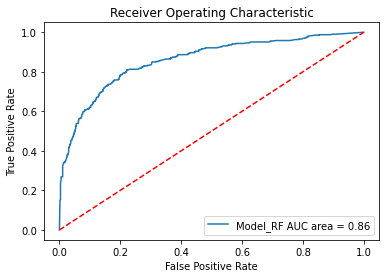

In [65]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, save_png = True)
result_img = '/results/roc_auc.png'
result_img


Super Vector Classifier (SVM)

In [66]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.77
Specificity: 0.86
AUC: 0.87


'/results/roc_auc.png'

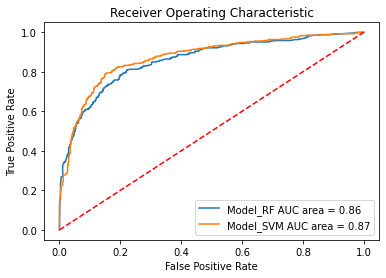

In [67]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '/results/roc_auc.png'
result_img

Neural Network Classifier (ANN)

In [68]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.70
Specificity: 0.84
AUC: 0.83


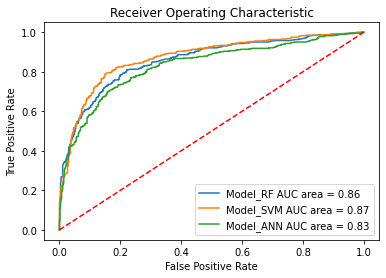

In [69]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '/results/roc_auc.png'
result_img
save_png = True

All three models (RF, SVM, ANN) show good values and therefore can be considered predictive

In [70]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [71]:
N_FOLDS = 3

In [72]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.79 	and std : 0.01 
Mean sensitivity: 0.72 	and std : 0.01 
Mean specificity: 0.84 	and std : 0.01 
Mean AUC: 0.86 	and std : 0.01 
Time taken : 2.29s


Model_SVM
Mean accuracy: 0.81 	and std : 0.01 
Mean sensitivity: 0.74 	and std : 0.00 
Mean specificity: 0.86 	and std : 0.02 
Mean AUC: 0.86 	and std : 0.01 
Time taken : 25.77s


Model_ANN
Mean accuracy: 0.75 	and std : 0.00 
Mean sensitivity: 0.65 	and std : 0.01 
Mean specificity: 0.83 	and std : 0.01 
Mean AUC: 0.82 	and std : 0.00 
Time taken : 8.72s



In [73]:
print(models)

[{'label': 'Model_RF', 'model': RandomForestClassifier(criterion='entropy')}, {'label': 'Model_SVM', 'model': SVC(C=1, gamma=0.1, probability=True)}, {'label': 'Model_ANN', 'model': MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)}]


Using Morgan fingerprint, we will look at the performance of the cross-validation

In [74]:
compound_df = compound_df.drop(['fp'], axis=1)

In [92]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(15)
# NBVAL_CHECK_OUTPUT

,Moleculue ChEMBL ID,Assay_Type,Smiles,relation,standard_value,type,pChEMBL_value,active,fp
0,CHEMBL732625,B,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,=,290.0,IC50,0.29,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL732625,B,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,=,290.0,IC50,0.29,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL732625,B,C[S+]([O-])c1cccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccn...,=,2100.0,IC50,2.10,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL732625,B,C[S+]([O-])c1ccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccnc...,=,4000.0,IC50,4.00,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL732625,B,Oc1ccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1,=,5700.0,IC50,5.70,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,CHEMBL732625,B,C[S+]([O-])c1ccc(CCCSc2nc(-c3ccc(F)cc3)c(-c3cc...,=,750.0,IC50,0.75,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,CHEMBL732625,B,CSc1cc(CSc2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)c...,=,3800.0,IC50,3.80,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,CHEMBL732625,B,C[S+]([O-])c1ccc(CSc2nc(-c3ccc(Br)cc3)c(-c3ccn...,=,3800.0,IC50,3.80,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,CHEMBL732625,B,C[S+]([O-])c1ccc(CSc2nc(-c3ccc(Cl)cc3)c(-c3ccn...,=,1400.0,IC50,1.40,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,CHEMBL732625,B,Fc1ccc(-c2[nH]c(CCc3ccccc3)nc2-c2ccncc2)cc1,=,690.0,IC50,0.69,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [76]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.81 	and std : 0.00 
Mean sensitivity: 0.76 	and std : 0.02 
Mean specificity: 0.86 	and std : 0.01 
Mean AUC: 0.88 	and std : 0.00 
Time taken : 8.03s


Model_ANN
Mean accuracy: 0.78 	and std : 0.01 
Mean sensitivity: 0.71 	and std : 0.01 
Mean specificity: 0.83 	and std : 0.01 
Mean AUC: 0.85 	and std : 0.00 
Time taken : 98.66s



In [77]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

In [78]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 3868
Test data size: 967


In [79]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

MAE: 390.29 	and std : 26.38 
RMSE: 3038.63 	and std : 531.39 



In [95]:
# The first entry is the co-crystalized ligand 
# which is added for reference (so we can compare 
# to its actual pChEMBL value)
# BELOW: add your own molecules
test_smiles = [
    
    'Oc1ccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1', #ZMA241385
    'Fc1ccc(-c2[nH]c(SCc3ccccc3)nc2-c2ccncc2)cc1'                        #Cafeine
]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

SMILES, PREDICTION
Oc1ccc(CSc2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1,6.53
Fc1ccc(-c2[nH]c(SCc3ccccc3)nc2-c2ccncc2)cc1,44.86
